<h1 style="font-size: 48px; font-weight: bold;">Creating a Multimodal Agent Using CrewAI and Watsonx</h1>


<h3 style="font-size: 20px;">This notebook help to Create a Multimodal Agent Using CrewAI, Watsonx using Llama 3.2 as vision model and Mistral as routing model</h3>

In [1]:
!pip install crewAI==0.51.0 | tail -n 1
!pip install langchain_community | tail -n 1
!pip install langchain_ibm | tail -n 1
!pip install ibm-watsonx-ai | tail -n 1
!pip install duckduckgo-search | tail -n 1
!pip install 'crewai[tools]' | tail -n 1

In [1]:
from crewai import Agent, Task, Crew, Process
from ibm_watsonx_ai.foundation_models import Model
from ibm_watsonx_ai.credentials import Credentials
import os
from langchain.llms.base import LLM
from typing import Any, List, Mapping, Optional
from langchain_ibm import WatsonxLLM
from langchain.tools import tool
import requests
import base64

**Connect to IBM watsonx model**

In [2]:
model_id = "mistralai/mistral-large"
parameters = {
    "decoding_method": "sample",
    "max_new_tokens": 500,
    "temperature": 0.7,
    "top_k": 50,
    "top_p": 1,
    "repetition_penalty": 1
}

In [3]:
api_key = "xxx"
project_id = "xxx"
url = "https://us-south.ml.cloud.ibm.com"

In [4]:
credentials = Credentials(url=url, api_key=api_key)

ibm_model = Model(
    model_id=model_id,
    params=parameters,
    credentials=credentials,
    project_id=project_id
)

**Tool for web search**

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
def web_search_tool(question: str) -> str:
    """This tool is useful when we want web search for current events."""
    # Function logic here
    # Step 1: Instantiate the Tavily client with your API key
    websearch = TavilySearchResults()
    # Step 2: Perform a search query
    response = websearch.invoke({"query":question})
    return response

**Tool for Image description**

In [6]:
def encode_image_to_base64(url):
    return base64.b64encode(requests.get(url).content).decode('utf-8')

## text to image function
def image2text(image_url:str,prompt:str) -> str:
    """This tool is useful when we want to generate textual descriptions from images."""

    encoded_image=encode_image_to_base64(image_url)
    # encoded_image=encode_image_to_base64('https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qCfuMka31-TxkNJw')
    
    url = "https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2023-05-29"

    system_prompt = '''You always answer the questions with markdown formatting using GitHub syntax. The markdown formatting you support: headings, bold, italic, links, tables, lists, code blocks, and blockquotes.
    You must omit that you answer the questions with markdown. Any HTML tags must be wrapped in block quotes, for example ```<html>```. You will be penalized for not rendering code in block quotes.
    When returning code blocks, specify language.\n\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.
    Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information. Please produce concise responses.
    '''
    
    body = {
    "messages": [{"role":"system","content":system_prompt}, {"role":"user","content":[{"type":"text","text":prompt},{"type":"image_url","image_url":{"url": f"data:image/jpeg;base64,{encoded_image}"}}]}],
	"project_id": "xxx",
	"model_id": "meta-llama/llama-3-2-90b-vision-instruct",
	"decoding_method": "greedy",
	"repetition_penalty": 1,
	"max_tokens": 500
    }
    
    headers = {
    	"Accept": "application/json",
    	"Content-Type": "application/json",
    	"Authorization": "Bearer xxx"    
    }

    response = requests.post(
    	url,
    	headers=headers,
    	json=body
    )
    
    if response.status_code != 200:
        raise Exception("Non-200 response: " + str(response.text))
    data = response.json()
    output = data['choices'][0]['message']['content']
    return "".join(output)

**Crewai Router tool**

In [10]:
from crewai_tools import tool
## Router Tool
@tool("router tool")
def router_tool(question:str) -> str:
    """Router Function"""
    prompt = f"""Based on the Question provide below determine the following:
    1. Is the question directed at describing the image ?
    2. Is the question a generic one and needs to be answered directly?
    Question: {question}
    
    RESPONSE INSTRUCTIONS:
    - Answer either 1 or 2.
    - Answer should strictly be a string.
    - Do not provide any preamble or explanations except for 1 or 2.
    
    OUTPUT FORMAT:
    1
    """
    # response = llm.invoke(prompt).content
    response = ibm_model.generate_text(prompt=prompt, guardrails=False)
    if response == "1":
        return 'image2text'
    elif response == "2":
        return 'web_search'
    else:
        return 'web_search'


**Crewai Retriever tool**

In [11]:
@tool("retriver tool")
def retriver_tool(router_response:str,question:str,image_url:str) -> str:
  """Retriver Function"""
  if router_response == 'image2text':
    return image2text(image_url,question)
  else:
    return web_search_tool(question)

**Custom watsonx LLM for crewai llm**

In [12]:
class IBMWatsonLLM(LLM):
    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        return ibm_model.generate_text(prompt=prompt, guardrails=False)

    @property
    def _llm_type(self) -> str:
        return "ibm_watson"

    def generate_text(self, prompt):
        return self._call(prompt)

In [13]:
custom_llm = IBMWatsonLLM()

**Router and retriever Agents and Tasks**

In [14]:
from crewai import Agent
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a image to text or web search',
  backstory=(
    "You are an expert at routing a user question to a image to text or web search."
    "Use the image to text to generate text describing the image based on the textual description."
    "Use the web search to search for current events."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=custom_llm,
  tools=[router_tool],
)

In [15]:
##Retriever Agent
Retriever_Agent = Agent(
    role="Retriever",
    goal="Use the information retrieved from the Router to answer the question and image url provided.",
    backstory=(
        "You are an assistant for directing tasks to respective agents based on the response from the Router."
        "Use the information from the Router to perform the respective task."
        "Do not provide any other explanation"
    ),
    verbose=True,
    allow_delegation=False,
    llm=custom_llm,
    tools=[retriver_tool],
)

In [16]:
from crewai import Task
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "If the question {question} instructs to describe a image then use the image url {image_url} to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "Based on the keywords decide whether it is eligible for a text to image or text to speech or web search."
    "Return a single word 'image2text' if it is eligible for describing the image based on the question {question} and iamge url{image_url}."
    "Return a single word 'web_search' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a choice 'web_search' or 'image2text' based on the question {question} and image url {image_url}"
    "Do not provide any preamble or explanations except for 'web_search' or 'image2text'."),
    agent=Router_Agent,
)

In [17]:
retriever_task = Task(
    description=("Based on the response from the 'router_task' generate response for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'web_search'."
    "Use the image2text tool to describe the image provide in the image url in case the router task output is 'image2text'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'web_search' then use the web_search_tool to retrieve information from the web."
    "If the response is 'image2text' then use the 'image2text' tool to describe the image based on the question {question} and {image_url}."
    ),
    agent=Retriever_Agent,
    context=[router_task],
)

**Create the crew**

In [18]:
from crewai import Crew,Process
crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,
)

**Test the image to text**

In [22]:
inputs ={"question":"Provide a detailed list of all the cereal boxes in the image.","image_url":"https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qCfuMka31-TxkNJw"}
result = crew.kickoff(inputs=inputs)

 [2024-09-30 16:43:32][DEBUG]: == Working Agent: Router
 [2024-09-30 16:43:32][INFO]: == Starting Task: Analyse the keywords in the question Provide a detailed list of all the cereal boxes in the image.If the question Provide a detailed list of all the cereal boxes in the image. instructs to describe a image then use the image url https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qCfuMka31-TxkNJw to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Provide a detailed list of all the cereal boxes in the image..Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'image2text' if it is eligible for describing the image based on the question Provide a detailed list of all the cereal boxes in the image. and iamge urlhttps://miro.medium.com/v2/resize:fit:1400/format:webp/0*qCfuMka31-TxkNJw.Return a single word 'web_search' if it is el

In [23]:
result.raw

"The image shows a grocery store shelf stocked with various cereal boxes. The cereals are arranged in rows, with some boxes facing forward and others turned sideways or backward. Here is a detailed list of the cereal boxes visible in the image:\n\n**Row 1 (Top):**\n\n* Blueberry Chex\n* Chocolate Chex\n* Cinnamon Chex\n* Honey Nut Chex\n* Wheat Chex\n* Crispix\n* Cracklin' Oat Bran\n* Wheaties\n\n**Row 2 (Middle):**\n\n* Raisin Bran\n* Rice Chex\n* Rice Squares\n* Rice Chex\n* Cheerios Oat Crunch\n* Cheerios Oat Crunch\n* Maple Cheerios\n* Toasted Oats\n\n**Row 3 (Bottom):**\n\n* Corn Chex\n* Corn Squares\n* Corn Chex\n* Corn Chex\n* Multi-Grain Cheerios\n* Life\n* Life\n* Life\n* Cheerios\n* Cheerios\n\nPlease note that this list only includes the cereal boxes that are fully visible in the image. There may be additional boxes partially hidden or out of view."

**The original image**

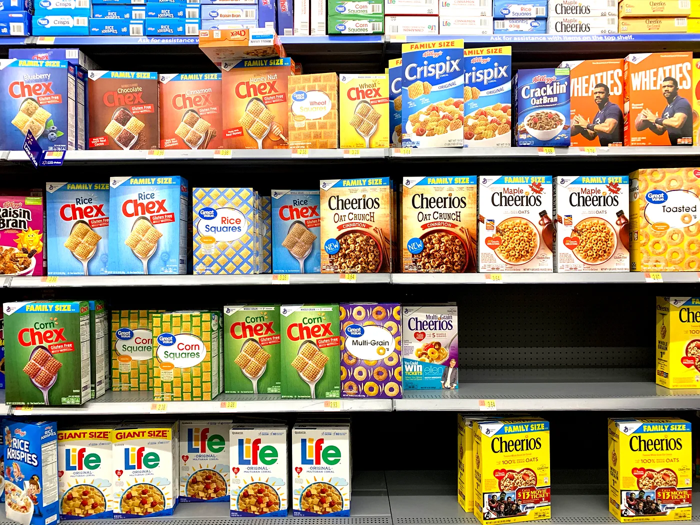

In [29]:
from PIL import Image
from io import BytesIO

response = requests.get("https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qCfuMka31-TxkNJw", stream=True)
img = Image.open(BytesIO(response.content))

# Resize the image
width, height = img.size
new_width = width // 2  # Reduce width by half
new_height = height // 2  # Reduce height by half
resized_img = img.resize((new_width, new_height))

# Display or save the resized image
resized_img.show() 

**The final answer**

In [25]:
from IPython.display import Markdown
Markdown(result.raw)

The image shows a grocery store shelf stocked with various cereal boxes. The cereals are arranged in rows, with some boxes facing forward and others turned sideways or backward. Here is a detailed list of the cereal boxes visible in the image:

**Row 1 (Top):**

* Blueberry Chex
* Chocolate Chex
* Cinnamon Chex
* Honey Nut Chex
* Wheat Chex
* Crispix
* Cracklin' Oat Bran
* Wheaties

**Row 2 (Middle):**

* Raisin Bran
* Rice Chex
* Rice Squares
* Rice Chex
* Cheerios Oat Crunch
* Cheerios Oat Crunch
* Maple Cheerios
* Toasted Oats

**Row 3 (Bottom):**

* Corn Chex
* Corn Squares
* Corn Chex
* Corn Chex
* Multi-Grain Cheerios
* Life
* Life
* Life
* Cheerios
* Cheerios

Please note that this list only includes the cereal boxes that are fully visible in the image. There may be additional boxes partially hidden or out of view.

**Credit** 

Anna Gutowska and Erika Russi - https://www.ibm.com/think/tutorials/multimodal-ai-python-llama

Plaban Nayak - https://medium.com/the-ai-forum/create-a-multimodal-agent-using-crewai-groq-and-replicate-ai-9e6cef31a20e

Aakriti Aggarwal - https://github.ibm.com/aakriti-aggarwal13/Agents/blob/main/Financial_Analyst_Crewai.ipynb?utm_source=ibm_developer&utm_content=in_content_link&utm_id=blogs_awb-leveraging-crewai-and-ibm-watsonx

@Yohan Bensoussan - AI architect, IBM